## Project: Computer simulation of a roadblock model of translational control
## Author: Gabin ROUSSEAU

#### Function arguments:

**t = time (number of iterations)**

**a = first site loading probability**

**b = final site unloading probability**

**p = site transition probability**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**k+ = roadblock binding rate**

**k- = roadblock unbinding rate**

__l* = length of the roadblock__

**B_i = liste of lattice indicies that can be subject to roadblock binding**


**State of an individual site** of index i = **Si** (i=1, ..., L)
With S = {1 if occupied, 0 if empty}

_**Note:** The state of occupation refers to a particle's tracked site exclusively, and the exclusion principle will take that into account to allow passage from one site to another. If all sites blocked by a particle were considered "occupied", it would cause problems when counting the particles on the lattice, especially if the model will end up having to qualify particle types._

**pi = probability of hopping from site i to site i+1** (for i=1,...,L-1) = assumed to be constant here. Should be equal to 1 for phase diagram testing!


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p1,...,pL-1]**


---
_roadblock_ini - v0.4_

## Notes for the implementation of a roadblock (mainly taken from Waclaw et al., 2019)
#### General description
A particle hops from site i to i  +  1 with rate p  if the arrival site i  +  1 is empty. If the arrival site contains a defect, the particle will be blocked. The defect can be thought as representing a physical obstacle blocking the particle. Defects appear and disappear stochastically within the site range indicated: a site without a defect can acquire one with rate k+ , whereas a defect site switches to a non-defect site with rate k.
While the paper suggests a simple model where any site can acquire a defect, defining a specific subset of sites that can be subjected to defect binding is reasonable.

#### New variables
This adds new variables: the defect or roadblocking configuration B (and an associated array of indicies that can receive roadblocks B_i), the defect binding rate k+, the defect unbinding rate k- and the block length l*.
The P array remains in use in case I want to add variations in local hopping rates.

#### Considerations
Should this change only happen as a particle directly approaches the blocked site, or be registered as soon as it is in the l range of sites ahead of the particle? Does it block completely or only reduce the rate?

The model will be constrained (roadblocks cannot bind where a particle is already present) by making the effective k+ "k+*", product of k+ and (1-Si). Likewise, if a roadblock manages to hop despite the reduced rate (if p > 0), does it remove the roadblock or does roadblock unbinding remain independent?

GILLESPIE-SPECIFIC: Do I add the defect dynamics as just one of the decisions that can be made at a given time point? (which affects the exponential distribution by changing the mean) Or should there be a concurrent decision specific to roadblocks?

Should roadblocks only be able to bind unoccupied sites? Needs thinking about how to formulate the conditions.





In [1]:
###############################################################################
#
#       roadblock_ini (rini) v0.4
#                               January 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

#rini dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random


import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import csv

#rini_AvB dependency
import statistics

#to wrap around iterables to display a progress bar
from tqdm import tqdm

In [2]:
#Core function for the model
def rini(t=100, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19]):
    '''
    
    roadblock_ini v0.4 
    (rini for short)
    
    DESCRIPTION:
    This is the 0.4 version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process self-adapts.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t:     number of iterations to run the TASEP model; DEFAULT: t=100
    L:     lattice length;                              DEFAULT: L=30
    l:     particle length;                             DEFAULT: l=1
    a:     rate of loading;                             DEFAULT: a=0.75
    b:     rate of unloading;                           DEFAULT: b=0.75
    p:     rate of scanning (i.e., site hopping);       DEFAULT: p=1
    k_on:  rate of blocking;                            DEFAULT: k_on=0.33 
    k_off: rate of unblocking;                          DEFAULT: k_off=0.33
    l_rb:  roadblock length;                            DEFAULT: l_rb=1
    B_i:   blockable lattice index list;                DEFAULT: B_i=[19]
    
    CHANGELOG:
    Changed formulaism to one matching the Gillespie algorithm, for a non-discrete timeline of events that are randomly determined in order and temporal spacing by a,b and p.
    Added to restriction rules: particles can't progress if a particle site is located l places ahead OR a block is located l' ahead (l' being the length of a block).
    With the addition of roadblocks of customisable length
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%2)==0:
                        blocked=B_i[int(i/2)]
                        B[blocked]+=1
                        A[i+L+1]=k_off #instantly flag the site as being unblockable
                    #unblocking
                    else:
                        unblocked=B_i[int((i-1)/2)]
                        B[unblocked]-=1
                        A[i+L]=0
    
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    else:  
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a rb?
                                if particle <= L-l-1: #can it be blocked by another particle?
                                    if C[particle+l]==0: #is it not blocked by a p?
                                        A[particle]=P[particle]
                                        
                                    else:
                                        A[particle]=0
                                else:
                                    A[particle]=P[particle]
                            else:
                                A[particle]=0
                        else:
                            A[particle]=P[particle]
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is place too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                        

                    
                    
            
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [4]:
#create a function that returns an initiation rate estimate
#for starters, calculate regression from time point t=L (to eliminate the expected phase of scanning for an uninterrupted first particle where the first initiation has yet to occur)
#note to self: exit flow: total exit count divided by time, might be even more relevant with Gillespie
def rini_I(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    rini_I for rini v0.4
    Estimates the initiation rate of the rini model as the simple exit current J=max(passed_total)/t.
    '''
    #Define the rini model run with the input parameters
    rini_data=rini(t,L,l,a,b,p) 
    
    I=max(rini_data['passed_total'])/t
    
        
    return round(I,2)

In [5]:
#Plots changes in exit rate over alpha and beta
def rini_IvAB(t=100, L=30, l=1, a=1, b=1, p=1, a_range=np.arange(0,1,0.02), b_range=np.arange(0,1,0.02), out=False):
    '''
    For rini v0.4
    Measures I against a range of alpha values and beta values respectively. In either case, a default value for the other parameter is set (default:0.75).
    Plots the comparison in two separate figures.
    The user can specify the range of values considered in addition to the base rini parameters in the form of numpy.arange() arrays.
    Optionally returns the dataset used for plotting.
    '''
    #open data dictionary
    IvAB={'alpha':[],'I_a':[], 'beta':[],'I_b':[]}
    
    #Tie initiation rates to variable alpha or beta values
    for alpha in a_range:
        IvAB.setdefault('alpha', []).append(alpha)
        IvAB.setdefault('I_a', []).append(rini_I(t, L, l, alpha, b, p))
    for beta in b_range:
        IvAB.setdefault('beta', []).append(beta)
        IvAB.setdefault('I_b', []).append(rini_I(t, L, l, a, beta, p))
    #convert to pandas dataframe
    IvAB_data= pd.DataFrame(data=IvAB)
    
    #plot
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.lineplot(x='alpha', y='I_a', data=IvAB_data)
    plt.xlabel('Alpha')
    plt.ylabel('Initiation rate')
    
    plt.subplot(122)
    sns.lineplot(x='beta', y='I_b', data=IvAB_data)
    plt.xlabel('Beta')
    plt.ylabel('Initiation rate')
    
    plt.tight_layout()
    plt.show();
    
    if out==True:
        print('Dataset returned.')
        return IvAB_data
        

In [7]:
#Plots the phase diagram
def rini_AvB(t=500, L=100, l=1, p=1, tags=False, randomised=False, n=10, B_i=[19]):
    '''
    For rini v0.4
    Plots alpha against beta. By default, plots 3 points expected to fit the respective density phases of TASEP and prints the median lattice occupation density over each point.
    If the 'randomised' argument is set to True, a selectable amount of points (n) will be made for random combinations of a and b.
    '''
    #open data dictionary
    AvB={'alpha':[], 'beta':[], 'mean_d':[], 'd_phase':[], 'expect_d':[]}
    
    if randomised==False:
        #prepare 3 points for LD, HD, and MC scenarios in order
        combi=[[0.25,0.75],[0.75,0.25],[0.75,0.75]]
        for a, b in combi:
            mean_density=statistics.mean(rini(t, L, l, a, b, p, B_i=B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>0.5 and b>0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
                
                
            
                        
    elif randomised==True:
        for i in range(n):
            a=round(random.uniform(0.1,1),2)
            b=round(random.uniform(0.1,1),2)
            mean_density=statistics.mean(rini(t, L, l, a, b, p, B_i=B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>0.5 and b>0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
            
        
        
    
    #convert to pandas dF
    AvB_data= pd.DataFrame(data=AvB)
    #plot AvB
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.scatterplot(x='alpha', y='beta', hue='d_phase', data=AvB_data)
    #frame the phases
    plt.plot([0,0.5], [0,0.5], color='r')
    plt.plot([0.5,0.5], [0.5,1.0], color='r')
    plt.plot([0.5,1.0], [0.5,0.5], color='r')
    
    #assign labels to points
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['alpha'][point]
            y=AvB_data['beta'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    #plot median vs. expected
    plt.subplot(122)
    plt.plot([0.0,1.0], [0.0,1.0], '--', color='r')
    sns.scatterplot(x='expect_d', y='mean_d', hue='d_phase', data=AvB_data)
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['expect_d'][point]
            y=AvB_data['mean_d'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1, step=0.1))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xlabel('Expected bulk density')
    plt.ylabel('Average occupation density')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    
    plt.tight_layout()
    plt.show();
    
    
    
    
    

In [8]:
#Plots the average occupancy for every site at a given time 
def rinimo(t=10000, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19], timepoint=5000, n=100, dataset=False, visual=True):
    '''
    For rini v0.4
    
    rinimo or "rini_mean_occupancy"
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    site=[] #columns for site numbers
    occupancy=[] #column for corresponding occupancies tallied n samples at time=timepoint
    for i in range(L):
        site.append(i+1)
        occupancy.append(0)
        
    
    
    #Launch n runs and tally occupancies
    for i in tqdm(range(n)):
        run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i)
        cropped_run=run.loc[run['time']<=timepoint]
        timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
        
        for ii in range(L):
            occupancy[ii]+=float(timed_run[f'S{ii+1}'].iloc[0])
    mean_occupancy=[occupied/n for occupied in occupancy]
    
    rinimo_data=pd.DataFrame(list(zip(site, mean_occupancy)), columns =['site', 'mean_occupancy'])
    
    if dataset==True:
        return rinimo_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.lineplot(x='site', y='mean_occupancy', color='orange', data=rinimo_data)
        if B_i!=[]:
            for i in B_i:
                plt.plot([i+1,i+1], [0,1],'--', color='r')
                
        
        plt.xticks(np.arange(0, L+2, step=2))
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Site number')
        plt.ylabel(f'Average occupancy at t={timepoint}')

        plt.tight_layout()
        plt.show();
    
        
    
    
    
        
    


In [3]:
#Plots a standardised initiation (protein production proxy) value against the number of blockable sites used
def rini_INIvBLOCK(t=10000, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19, 24], timepoint=10000, n=10, dataset=False, visual=True):
    '''
    For rini v0.4
    
    rini_INIvBLOCK: function to plot a standardised measure of the exit count (represents initiation/protein production) against the number of blocks.
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    repetition=[] #column for repetition IDs
    blocks=[] #columns for blockable site counts
    exits=[] #column for standardised mean exits
      
    blockcount=len(B_i)+1
    
    
    #Launch n runs and calculate standardised mean exits
    exits_zero=0 #tally exits for zero blocks to establish a mean standard
    #loop for as many repetitions as required
    for i in tqdm(range(n)):
        #record total particle exits for each block scenario
        for ii in range(blockcount):
            
            current_run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i[0:ii])
            cropped_run=current_run.loc[current_run['time']<=timepoint]
            timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
            
           
            repetition.append(i)
            blocks.append(ii)
            current_exits=float(timed_run['passed_total'].iloc[0])
            exits.append(current_exits)
            if ii == 0:
                exits_zero+=current_exits
    mean_exits_zero=exits_zero/n        
    standardised_exits=[x/mean_exits_zero for x in exits]   
    
    rini_INIvBLOCK_data=pd.DataFrame(list(zip(repetition, blocks, standardised_exits)), columns = ['repetition_number', 'block_number','initiation'])
    
    if dataset==True:
        return rini_INIvBLOCK_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.pointplot(x='block_number', y='initiation', errorbar="sd", data=rini_INIvBLOCK_data)
                
        
        #plt.xticks(np.arange(0, L+2, step=2))
        #plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Number of blockable sites')
        plt.ylabel('Initiation efficiency')
        plt.title(f'Initiation efficiency vs. number of blocks | Sites:{[x+1 for x in B_i]} | Pb = {round(k_on/(k_on+k_off)*100,1)}% | n = {n}')

        plt.tight_layout()
        plt.show();

In [10]:
#testing rini sampling at the closest timepoint below a chosen value
run=rini(t=10000)
cropped_run=run.loc[run['time']<=5000]
timed_run=cropped_run.iloc[(cropped_run['time']-5000).abs().argsort()[:1]]
float(timed_run['S2'].iloc[0])

0.0

In [6]:
#Check the output of rini
model_test=rini(t=10000,l=3,l_rb=2,B_i=[1,8,9,19,25])
model_test
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/table2.csv')

,time,passed_total,density,S1,S2,S3,S4,S5,S6,S7,...,S26,S27,S28,S29,S30,B2,B9,B10,B20,B26
0,0.000000,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.106918,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.667423,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,2.024165,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
4,3.176290,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38634,9999.445609,1081,0.20,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
38635,9999.733433,1081,0.20,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
38636,9999.805461,1081,0.20,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
38637,9999.808107,1081,0.23,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [47]:
#Visualise the exits over time + linear regression used to determine the rate
rini_I(t=10000)

0.22

In [265]:
#Visualise the exits + regression when a rate is severely limiting the progress of the model
rini_I(t=10000, L=30, l=1, a=0.01, b=1, p=1)

0.01

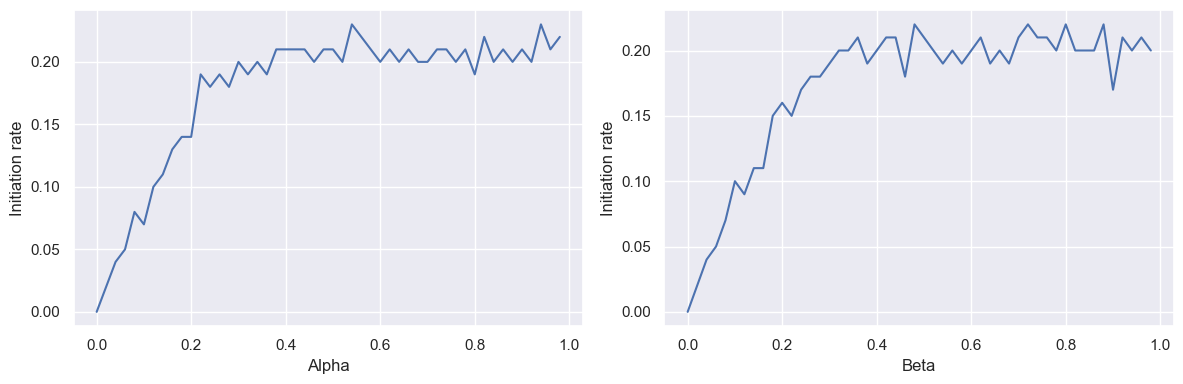

In [48]:
#Visualise changes in the initiation rate depending on either alpha or beta
#On the left, b=1; on the right, a=1
rini_IvAB(1000)

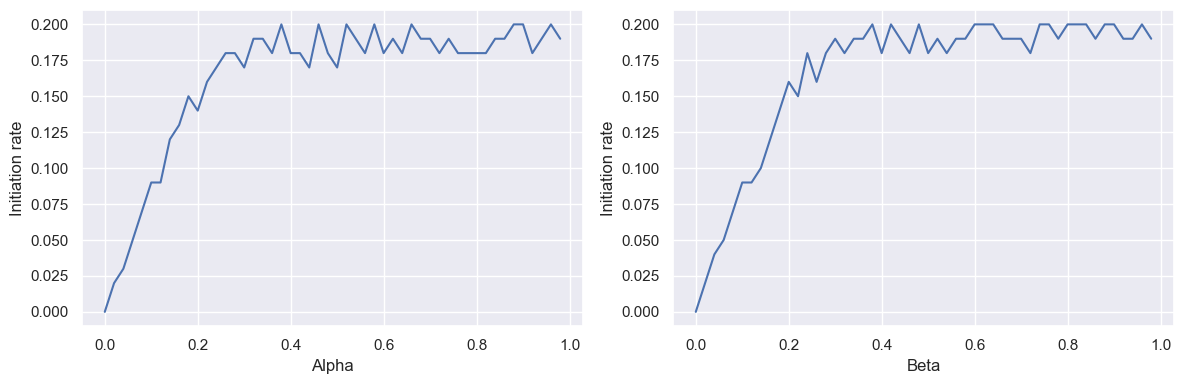

In [49]:
#Same as above but the constant rates are 0.3 instead of 1.
rini_IvAB(a=0.3,b=0.3,t=1000)

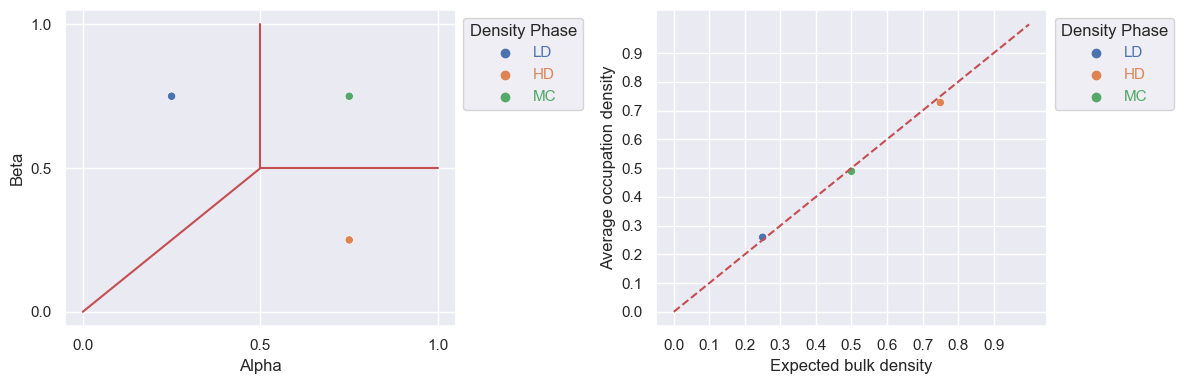

In [5]:
#Plot a phase diagram with a representative point for each phase
rini_AvB(t=10000,B_i=[])

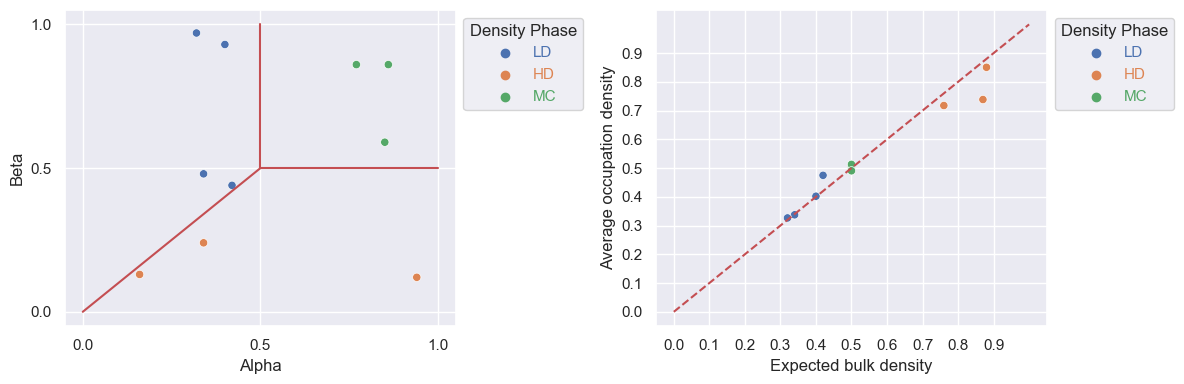

In [6]:
#Phase diagram with 10 random points
rini_AvB(randomised=True, n=10,t=10000, B_i=[])

In [7]:
#affix a run of rini to a variable and save the table if needed
model_test=rini(t=10000)
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/table.csv')

In [8]:
#count the time percentage during which the blocked site was occupied in model_test, express the probability of blocking Pb
B_count=len(model_test['B20'].loc[model_test['B20']==1])
run_len=len(model_test['B20'])
Pb=0.5

print(f'Site 20 was blocked {B_count/run_len*100}% of the time. Pb = {Pb}')

Site 20 was blocked 27.659544037300837% of the time. Pb = 0.5


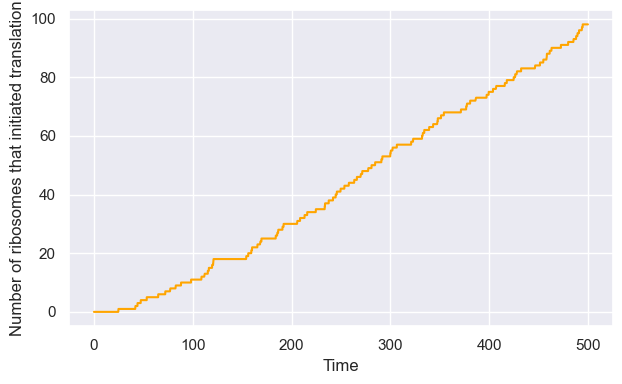

In [54]:
#INITIATED VS. TIME model_test
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test, color='orange')

plt.xlabel('Time')
plt.ylabel('Number of ribosomes that initiated translation')

plt.tight_layout()
plt.show();

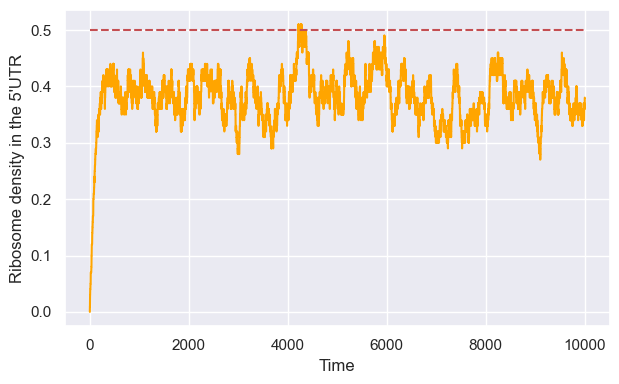

In [55]:
#DENSITY VS. TIME Max current (a and b >1/2)
#EXPECTED: d=1/2
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(t=10000, L=100), color='orange')
plt.plot([0,10000], [0.5,0.5], '--',color='r')

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

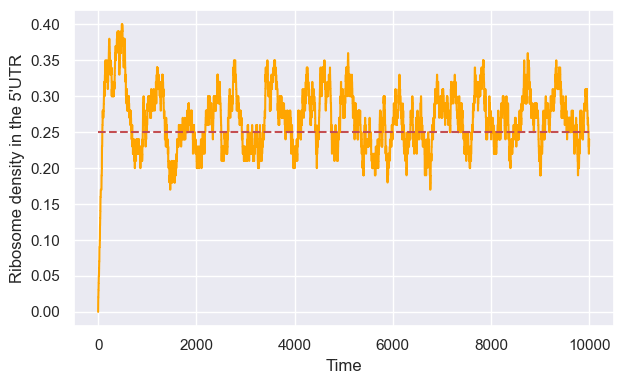

In [56]:
#DENSITY VS. TIME Low density (a < 1/2 and a < b)
#EXPECTED: d=a (0.25 here)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(a=0.25, t=10000, L=100), color='orange')
plt.plot([0,10000], [0.25,0.25], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

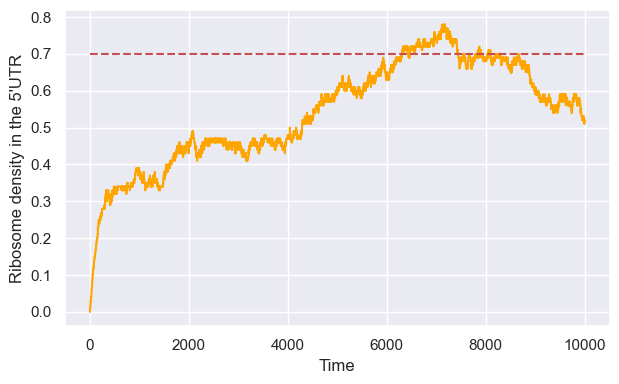

In [9]:
#DENSITY VS. TIME High density (b < 1/2 and a > b)
#EXPECTED: d=1-b (b=0.3 here so 0.7)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(b=0.3,t=10000,L=200), color='orange')
plt.plot([0,10000], [0.7,0.7], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


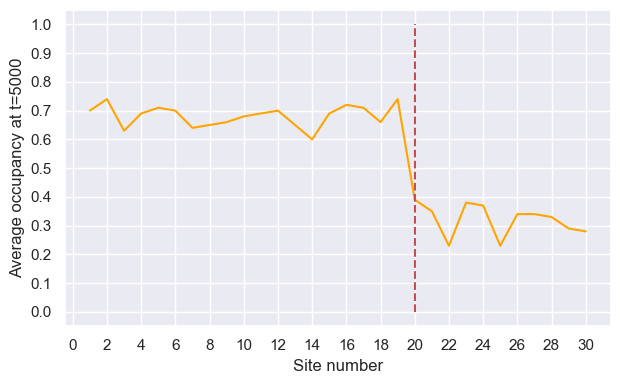

In [39]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=5000, runtime 10000, n=100 samples, L=30, block at site 20, Pb=0.5
rinimo()

100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


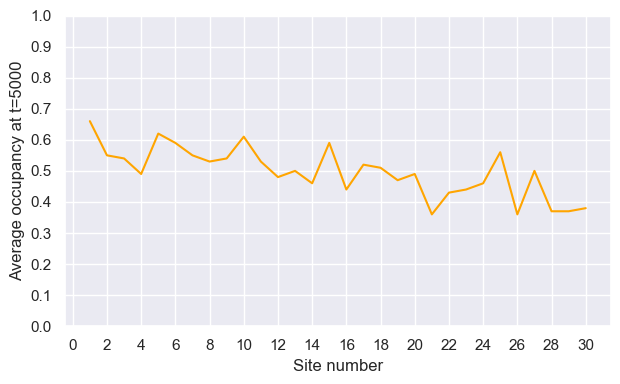

In [35]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=5000, runtime 10000, n=100 samples, L=30, no blockable site
rinimo(B_i=[])

100%|██████████| 1000/1000 [33:56<00:00,  2.04s/it]


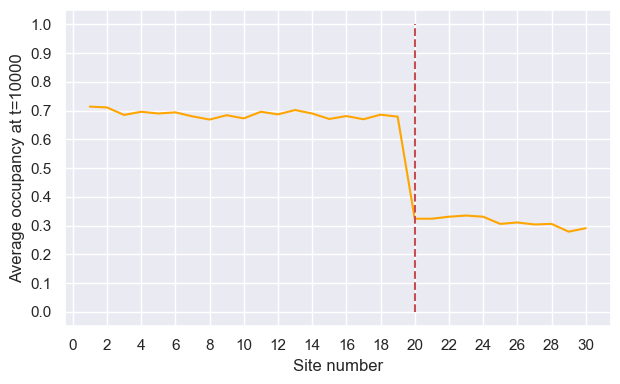

In [40]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=10000, n=1000 samples, L=30, block at site 20, Pb=0.5 (0.33/0.33)
rinimo(timepoint=10000,n=1000)

100%|██████████| 1000/1000 [37:04<00:00,  2.22s/it]


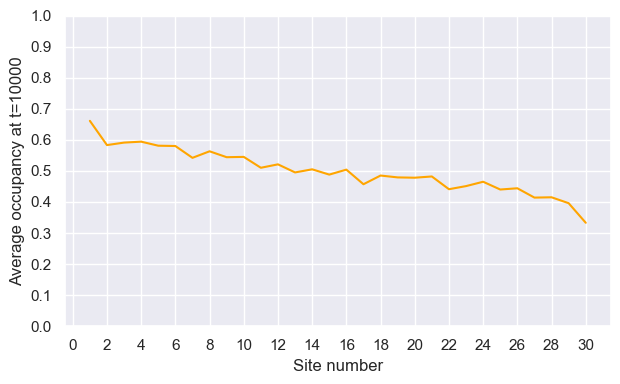

In [41]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=10000, n=1000 samples, L=30, no blockable site
rinimo(timepoint=10000,n=1000,B_i=[])

100%|██████████| 200/200 [10:23<00:00,  3.12s/it]


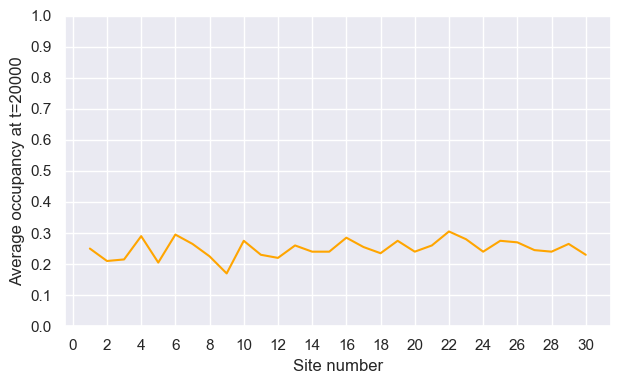

In [10]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=20000, n=200 samples, L=30, no blockable site, a= 1-b
rinimo(t=20000,L=30,a=0.25,b=0.75,timepoint=20000,n=200,B_i=[])


In [11]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=20000, n=200 samples, L=200, no blockable site, a and b =0.75
rinimo(t=20000,L=200,a=0.75,b=0.75,timepoint=20000,n=200,B_i=[])


  0%|          | 1/200 [03:55<12:59:43, 235.09s/it]


KeyboardInterrupt: 

In [30]:
#SAVE THE RINIMO DATASET T=5000, runtime 10000, n=100 samples, L=30
test=rinimo(dataset=True, visual=False)
#test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/rinimo_table.csv')

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


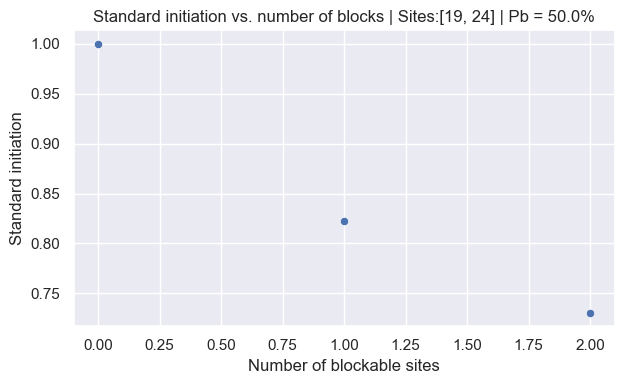

In [14]:
# 1 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks
rini_INIvBLOCK(t=5000,timepoint=5000,n=10)

100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


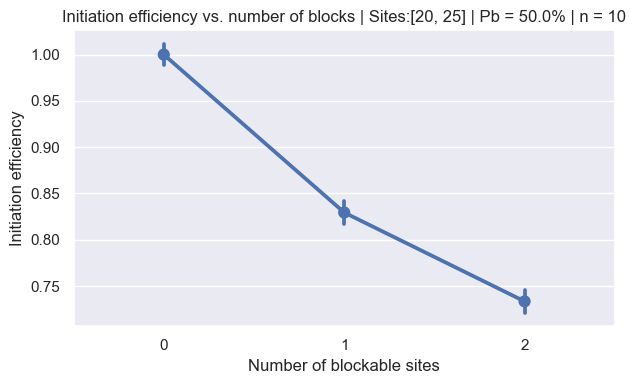

In [27]:
#2 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks, Pb=50.0%

rini_INIvBLOCK(t=5000,timepoint=5000,n=10)


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


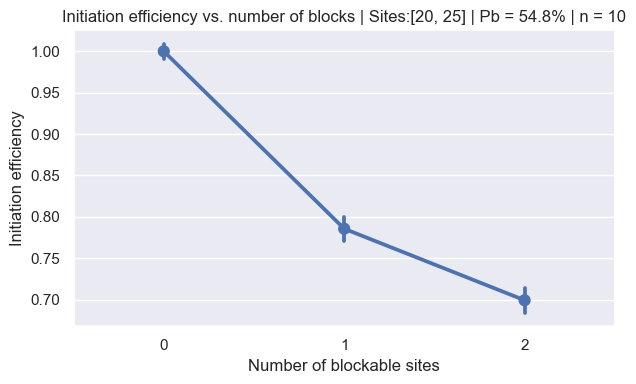

In [29]:
#3 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10, k_on=0.4)

100%|██████████| 10/10 [03:24<00:00, 20.47s/it]


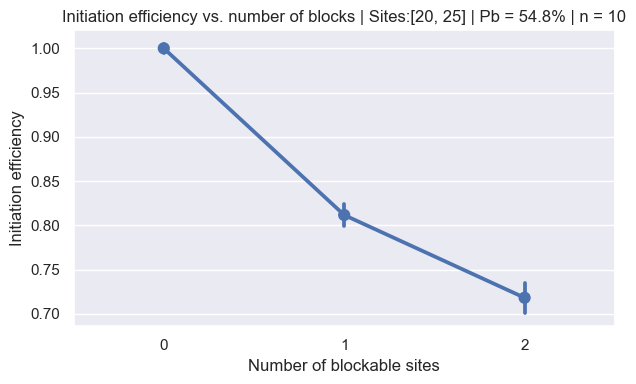

In [30]:
#4 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10,L=100, up to 2 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10,L=100, k_on=0.4)

100%|██████████| 10/10 [01:53<00:00, 11.36s/it]


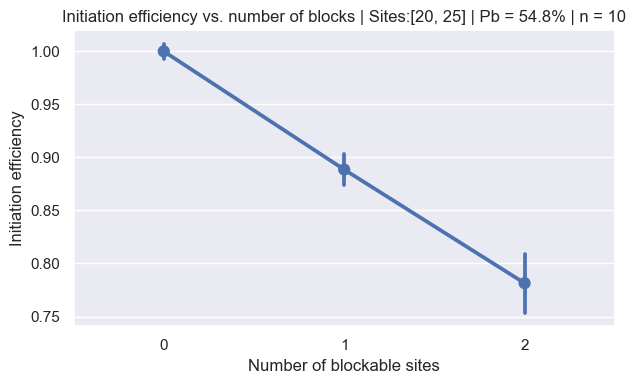

In [31]:
#5 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10,L=100,l=3, up to 2 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10,L=100,l=3, k_on=0.4)

100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


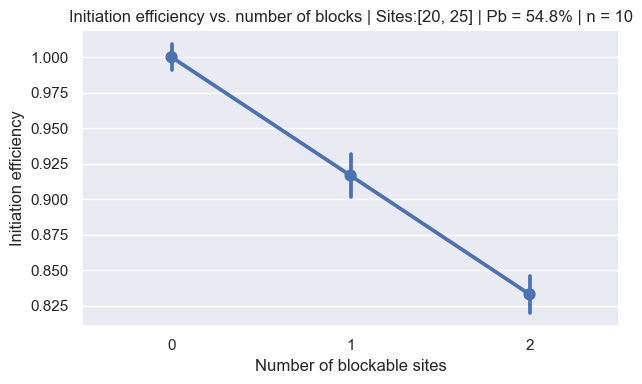

In [32]:
#6 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10,L=100,l=6, up to 2 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10,L=100,l=6, k_on=0.4)

100%|██████████| 10/10 [02:36<00:00, 15.65s/it]


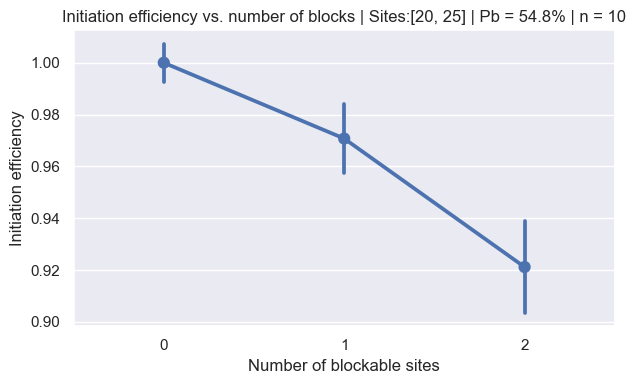

In [33]:
#7 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10,L=200,l=12,l_rb=2, up to 2 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10,L=200,l=12,l_rb=2, k_on=0.4)

100%|██████████| 10/10 [00:56<00:00,  5.69s/it]


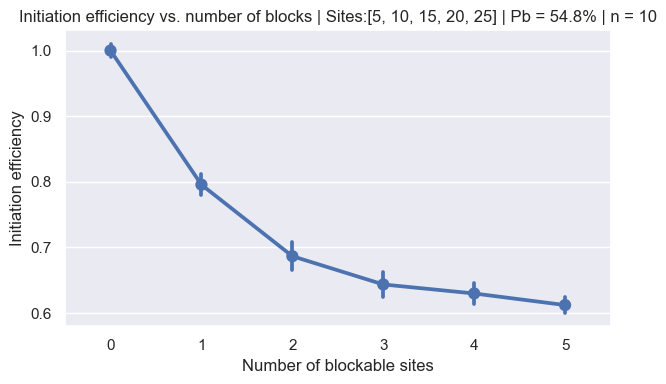

In [35]:
#8 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 5 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10, k_on=0.4, B_i=[4,9,14,19,24])

100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


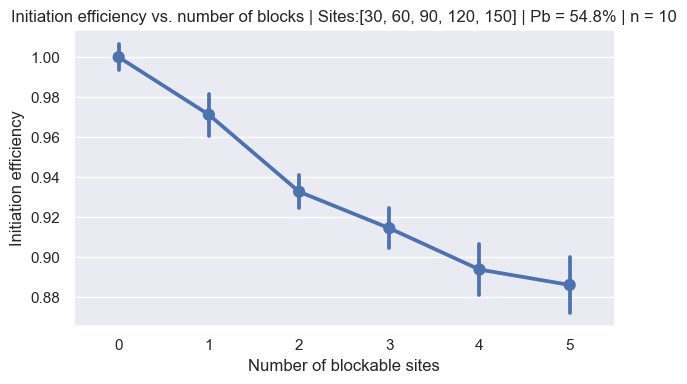

In [36]:
#9 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10,L=200,l=12,l_rb=2, up to 5 blocks, Pb=54.8%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10,L=200,l=12,l_rb=2, k_on=0.4,B_i=[29,59,89,119,149])

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


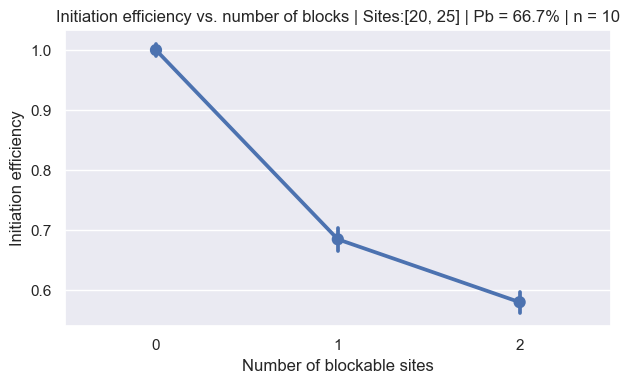

In [28]:
#10 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks, Pb=66.7%
rini_INIvBLOCK(t=5000,timepoint=5000,n=10, k_on=0.66)

100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


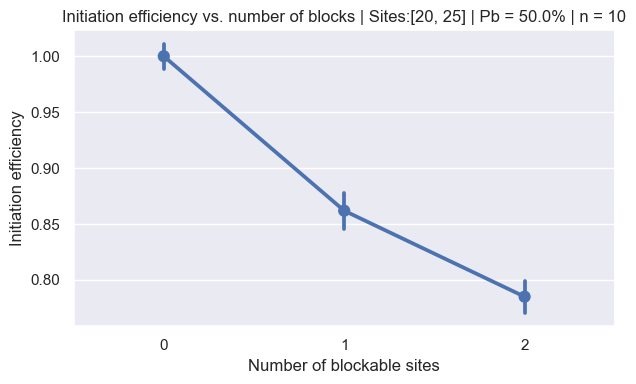

In [5]:
#11 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks, Pb=50% (but the on/off rates are higher than #1)
rini_INIvBLOCK(t=5000,timepoint=5000,n=10, k_on=0.7,k_off=0.7)

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


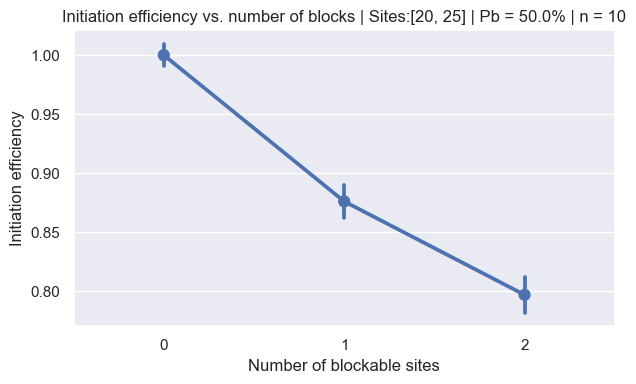

In [6]:
#12 - PLOT THE INITIATION VS. BLOCKS PROFILE t=5000, n=10, up to 2 blocks, Pb=50% (but the on/off rates are even higher than #11)
rini_INIvBLOCK(t=5000,timepoint=5000,n=10, k_on=0.95,k_off=0.95)

100%|██████████| 10/10 [00:59<00:00,  5.95s/it]


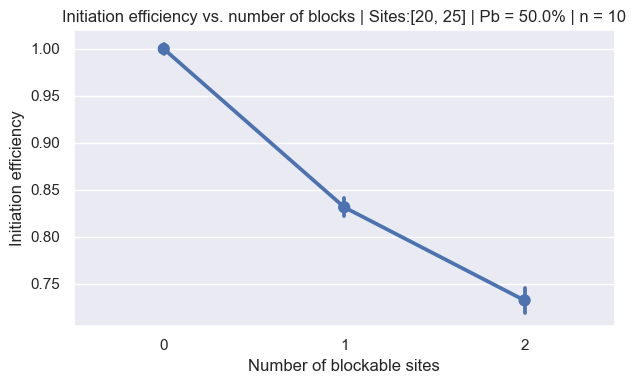

In [7]:
#13 - PLOT THE INITIATION VS. BLOCKS PROFILE t=10000, n=10, up to 2 blocks, Pb=50% (time is doubled)
rini_INIvBLOCK(t=10000,timepoint=10000,n=10, k_on=0.33,k_off=0.33)


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


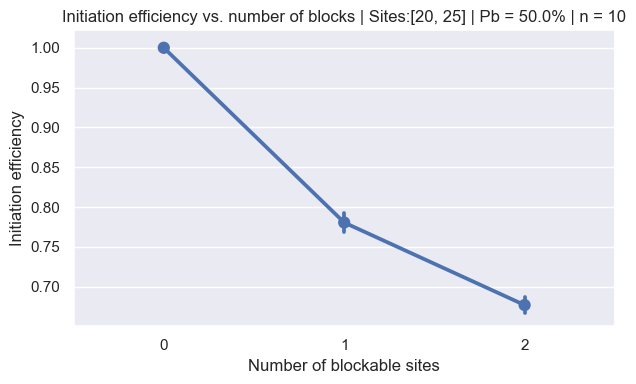

In [8]:
#14 - PLOT THE INITIATION VS. BLOCKS PROFILE t=10000, n=10, up to 2 blocks, Pb=50% (time is doubled, default k rates are halved)
rini_INIvBLOCK(t=10000,timepoint=10000,n=10, k_on=0.165,k_off=0.165)